In [1]:
import os
import numpy as np
import cv2
import transformations
import scipy.io as sio
import glob
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import sys
import data_generation
import networks
import param
import util
import truncated_vgg
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam

Using TensorFlow backend.


In [7]:
vid_info_list = data_generation.make_vid_info_list('/mnt/data/jarvislam1999/posewarp-cvpr2018/data/test')

In [8]:
vid_info_list[0]

[{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sun Jan 28 13:13:59 2018',
  '__version__': '1.0',
  '__globals__': [],
  'data': array([[ (array([[[ 751.29189687,  727.71915285,  715.93278085,  704.14640884,
            706.50368324,  645.2145488 ,  723.00460405,  692.36003683],
          [ 125.95119705,  118.87937385,  130.66574586,  140.09484346,
            142.45211786,  128.30847145,  125.95119705,  137.73756906]],
  
         [[ 756.00644567,  734.79097606,  727.71915285,  706.50368324,
            713.57550645,  664.07274401,  734.79097606,  711.21823204],
          [ 203.7412523 ,  201.3839779 ,  215.52762431,  222.59944751,
            224.95672192,  213.17034991,  208.4558011 ,  227.31399632]],
  
         [[ 706.50368324,  675.85911602,  685.28821363,  668.78729282,
            673.50184162,  623.99907919,  697.07458564,  666.43001842],
          [ 239.10036832,  232.02854512,  224.95672192,  234.38581952,
            246.17219153,  232.02854512,  236.7

In [4]:
vid = np.random.choice(len(vid_info_list), 1)[0]
vid

0

In [12]:
np.array(vid_info_list).shape

(1, 4)

In [15]:
# 1. choose random video.
vid = np.random.choice(len(vid_info_list), 1)[0]

vid_bbox = vid_info_list[vid][1]
vid_x = vid_info_list[vid][2]
vid_path = vid_info_list[vid][3]

In [16]:
vid_path

'/mnt/data/jarvislam1999/posewarp-cvpr2018/data/test/frames/Golf Lessons - Stop Topping Fairway Woods'

In [17]:
vid_bbox.shape

(8, 4)

In [18]:
vid_x.shape

(14, 2, 8)

In [20]:
vid_x[:,:,0]

array([[ 751.29189687,  125.95119705],
       [ 756.00644567,  203.7412523 ],
       [ 706.50368324,  239.10036832],
       [ 687.64548803,  290.96040516],
       [ 725.36187845,  302.74677716],
       [ 807.8664825 ,  210.81307551],
       [ 857.36924494,  253.24401473],
       [ 892.72836096,  298.03222836],
       [ 723.00460405,  349.89226519],
       [ 732.43370166,  465.39871087],
       [ 748.93462247,  559.68968692],
       [ 786.65101289,  361.6786372 ],
       [ 786.65101289,  474.82780847],
       [ 720.64732965,  547.90331492]])

In [21]:
img_01 = Image.open(vid_path + '/1.jpg')

In [22]:
img_01 = np.array(img_01, dtype=np.uint8)

In [13]:
vid_info_list[0][1]

array([[ 687.64548803,  125.95119705,  205.08287293,  433.73848987],
       [ 652.28637201,  118.87937385,  169.72375691,  497.38489871],
       [ 635.7854512 ,  130.66574586,  169.72375691,  469.09760589],
       [ 621.64180479,  140.09484346,  150.86556169,  438.45303867],
       [ 673.50184162,  142.45211786,  106.07734807,  424.30939227],
       [ 623.99907919,  128.30847145,  124.93554328,  445.52486188],
       [ 697.07458564,  125.95119705,  157.9373849 ,  464.38305709],
       [ 657.00092081,  137.73756906,  132.00736648,  447.88213628]])

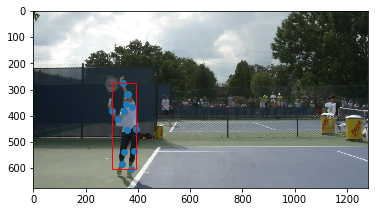

In [28]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_01)

# Create a Rectangle patch
rect = patches.Rectangle((vid_info_list[0][1][0][0],\
                          vid_info_list[0][1][0][1]),\
                         vid_info_list[0][1][0][2],\
                         vid_info_list[0][1][0][3],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.scatter(vid_x[:,0,0], vid_x[:,1,0])

plt.show()

In [79]:
len(vid_info_list[0][2])

14

In [80]:
vid_info_list[0][2][3]

array([[ 322.9390564 ,  510.78391167,  322.87390137,  304.31832886,
         369.4510498 ,  325.77346802,  346.82519531,  371.14224243],
       [ 410.61090088,  315.78706625,  408.60202026,  380.29504395,
         411.53659058,  404.66845703,  422.09875488,  410.38949585]])

In [81]:
params = param.get_general_params()
img_width = params['IMG_WIDTH']
img_height = params['IMG_HEIGHT']
pose_dn = params['posemap_downsample']
sigma_joint = params['sigma_joint']
n_joints = params['n_joints']
scale_factor = params['obj_scale_factor']
batch_size = params['batch_size']
limbs = params['limbs']
n_limbs = params['n_limbs']

# 1. choose random video.
vid = np.random.choice(len(vid_info_list), 1)[0]

vid_bbox = vid_info_list[vid][1]
vid_x = vid_info_list[vid][2]
vid_path = vid_info_list[vid][3]

# 2. choose pair of frames
n_frames = vid_x.shape[2]
frames = np.random.choice(n_frames, 2, replace=False)
while abs(frames[0] - frames[1]) / (n_frames * 1.0) <= 0.02:
    frames = np.random.choice(n_frames, 2, replace=False)

I0, joints0, scale0, pos0 = data_generation.read_frame(vid_path, frames[0], vid_bbox, vid_x)
I1, joints1, scale1, pos1 = data_generation.read_frame(vid_path, frames[1], vid_bbox, vid_x)

In [82]:
n_frames

8

In [83]:
frames

array([3, 6])

In [84]:
joints = vid_x[:, :, 0] - 1.0
box_frame = vid_bbox[0, :]
scale = data_generation.get_person_scale(joints)
pos = np.zeros(2)
pos[0] = (box_frame[0] + box_frame[2] / 2.0)
pos[1] = (box_frame[1] + box_frame[3] / 2.0)

In [85]:
joints

array([[ 358.36435331,  316.80599369],
       [ 354.32649842,  355.16561514],
       [ 346.25078864,  381.41167192],
       [ 321.9390564 ,  409.61090088],
       [ 301.83438486,  381.41167192],
       [ 376.53470032,  365.26025237],
       [ 362.4022082 ,  314.78706625],
       [ 341.69271851,  273.47024536],
       [ 357.68118286,  453.33328247],
       [ 344.99520874,  536.0055542 ],
       [ 339.37304688,  584.12249756],
       [ 392.66873169,  449.1137085 ],
       [ 384.28167725,  535.37414551],
       [ 372.97335815,  604.33795166]])

In [86]:
box_frame

array([ 302.83438486,  274.47024536,   90.83434683,  330.8677063 ])

In [87]:
scale

1.6802187724068347

In [88]:
params

{'IMG_HEIGHT': 256,
 'IMG_WIDTH': 256,
 'batch_size': 4,
 'data_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018/data',
 'limbs': [[0, 1],
  [2, 3],
  [3, 4],
  [5, 6],
  [6, 7],
  [8, 9],
  [9, 10],
  [11, 12],
  [12, 13],
  [2, 5, 8, 11]],
 'max_px_shift': 10,
 'max_rotate_degree': 5,
 'max_sat_factor': 0.05,
 'model_save_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018/models',
 'model_save_interval': 1000,
 'n_joints': 14,
 'n_limbs': 10,
 'n_training_iter': 200000,
 'obj_scale_factor': 1.14,
 'posemap_downsample': 2,
 'project_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018',
 'scale_max': 1.05,
 'scale_min': 0.9,
 'sigma_joint': 1.75,
 'test_interval': 500}

In [89]:
vid_info_list

[[{'__globals__': [],
   '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Jun 12 10:28:41 2017',
   '__version__': '1.0',
   'data': array([[ (array([[[ 359.36435331,  464.34858044,  354.60473633,  365.42113565,
             401.34921265,  346.27957153,  393.68611987,  417.99417114],
           [ 317.80599369,  303.67350158,  301.99597168,  301.65457413,
             303.14028931,  297.28875732,  323.86277603,  293.24758911]],
   
          [[ 355.32649842,  472.42429022,  335.74038696,  369.15231323,
             379.6444397 ,  333.3140564 ,  405.58459473,  398.0475769 ],
           [ 356.16561514,  342.03312303,  356.05395508,  358.50415039,
             358.1630249 ,  353.82574463,  375.67178345,  346.71148682]],
   
          [[ 347.25078864,  464.34858044,  306.73614502,  348.79367065,
             352.12799072,  305.71014404,  383.42163086,  376.47003174],
           [ 382.41167192,  335.97634069,  363.36676025,  363.94567871,
             364.56881714,  362

In [90]:
train_feed = data_generation.warp_example_generator(vid_info_list, params)

In [91]:
x, y = next(train_feed)

In [92]:
len(x)

5

In [93]:
len(y)

4

In [94]:
x

[array([[[[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [-0.4052485 , -0.4424605 , -0.5261151 ],
          ..., 
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [-0.47726352, -0.52139331, -0.60229793],
          ..., 
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [-0.49988234, -0.54401214, -0.62491676],
          ..., 
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         ..., 
         [

In [95]:
y

array([[[[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [-0.24976629, -0.30825099, -0.40073509],
         ..., 
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [-0.22359239, -0.28859525, -0.38532621],
         ..., 
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [-0.21030284, -0.26983309, -0.37075824],
         ..., 
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        ..., 
        [[ 0.        ,  0.        ,

In [96]:

x_ = np.array(x[2])

In [97]:
x_.shape

(4, 128, 128, 14)

In [98]:
img_x = Image.fromarray(x_[1], 'RGB')

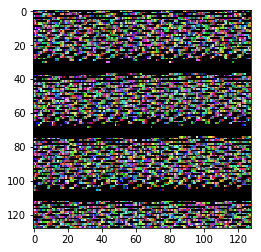

In [99]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_x)

plt.show()

In [100]:
I0

array([[[ 44,  51,  44],
        [ 31,  38,  31],
        [ 27,  35,  28],
        ..., 
        [ 32,  43,  35],
        [ 32,  43,  35],
        [ 30,  41,  33]],

       [[ 25,  32,  25],
        [ 29,  36,  29],
        [ 31,  39,  32],
        ..., 
        [ 32,  43,  35],
        [ 33,  44,  36],
        [ 32,  43,  35]],

       [[ 21,  28,  21],
        [ 37,  44,  37],
        [ 42,  50,  43],
        ..., 
        [ 31,  42,  34],
        [ 33,  44,  36],
        [ 35,  46,  38]],

       ..., 
       [[123, 142, 133],
        [124, 143, 134],
        [125, 144, 135],
        ..., 
        [148, 129, 116],
        [148, 129, 116],
        [148, 129, 116]],

       [[123, 142, 133],
        [124, 143, 134],
        [125, 144, 135],
        ..., 
        [148, 129, 116],
        [148, 129, 116],
        [148, 129, 116]],

       [[123, 142, 133],
        [124, 143, 134],
        [125, 144, 135],
        ..., 
        [148, 129, 116],
        [148, 129, 116],
        [148, 129,

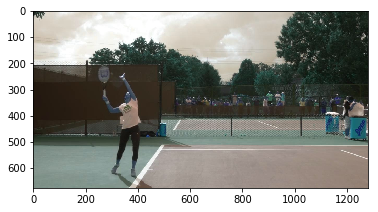

In [101]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(I0)

plt.show()

In [102]:
pos = (pos0 + pos1) / 2.0

I0, joints0 = data_generation.center_and_scale_image(I0, img_width, img_height, pos, scale, joints0)
I1, joints1 = data_generation.center_and_scale_image(I1, img_width, img_height, pos, scale, joints1)

I0 = (I0 / 255.0 - 0.5) * 2.0
I1 = (I1 / 255.0 - 0.5) * 2.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


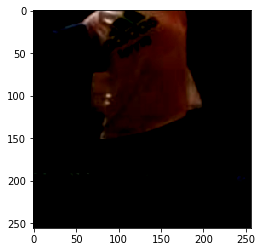

In [103]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(I0)

plt.show()

In [104]:
rflip, rscale, rshift, rdegree, rsat = data_generation.rand_augmentations(params)
I0, joints0 = data_generation.augment(I0, joints0, rflip, rscale, rshift, rdegree, rsat, img_height, img_width)
I1, joints1 = data_generation.augment(I1, joints1, rflip, rscale, rshift, rdegree, rsat, img_height, img_width)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


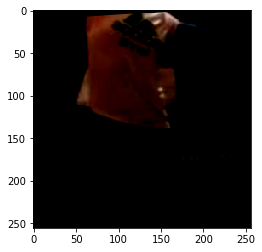

In [105]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(I0)

plt.show()

In [113]:
data_dir = '/mnt/data/jarvislam1999/posewarp-cvpr2018/data/train'
vids = glob.glob('/mnt/data/jarvislam1999/posewarp-cvpr2018/data/train' + '/frames/*')
n_vids = len(vids)

vid_info = []

for i in range(n_vids):
    path, vid_name = os.path.split(vids[i])
    info_name = data_dir + '/info/' + vid_name + '.mat'
    info = sio.loadmat(info_name)

    box = info['data']['bbox'][0][0]
    x = info['data']['X'][0][0]

    vid_info.append([info, box, x, vids[i]])

In [114]:
np.array(x).shape

(14, 2, 8)

In [115]:
x[:,:,0]

array([[ 359.36435331,  317.80599369],
       [ 355.32649842,  356.16561514],
       [ 347.25078864,  382.41167192],
       [ 322.9390564 ,  410.61090088],
       [ 302.83438486,  382.41167192],
       [ 377.53470032,  366.26025237],
       [ 363.4022082 ,  315.78706625],
       [ 342.69271851,  274.47024536],
       [ 358.68118286,  454.33328247],
       [ 345.99520874,  537.0055542 ],
       [ 340.37304688,  585.12249756],
       [ 393.66873169,  450.1137085 ],
       [ 385.28167725,  536.37414551],
       [ 373.97335815,  605.33795166]])

In [129]:
img_01 = Image.open('/mnt/data/jarvislam1999/posewarp-cvpr2018/data/train/frames/Flavia Pennetta in 4k/2.jpg')

In [130]:
img_01 = np.array(img_01, dtype=np.uint8)

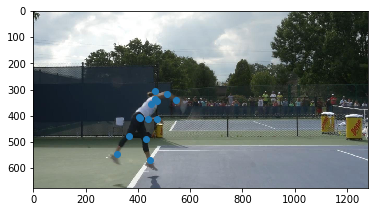

In [132]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_01)

x_in = x[:,0,1]
y_in = x[:,1,1]
plt.scatter(x_in, y_in)
plt.show()

In [127]:
len(x[:,1,0])

14

In [140]:
vid_info[0][3]

'/mnt/data/jarvislam1999/posewarp-cvpr2018/data/train/frames/Flavia Pennetta in 4k'

In [141]:
train_feed = data_generation.create_feed(params, params['data_dir'], 'train')

In [143]:
vgg_model = truncated_vgg.vgg_norm()
networks.make_trainable(vgg_model, False)
response_weights = sio.loadmat('../data/vgg_activation_distribution_train.mat')
model = networks.network_posewarp(params)
model.compile(optimizer=Adam(lr=1e-4), loss=[networks.vgg_loss(vgg_model, response_weights, 12)])

Instructions for updating:
Colocations handled automatically by placer.


In [145]:
x

[array([[[[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          ..., 
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          ..., 
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          ..., 
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],
 
         ..., 
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          ..., 
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          ..., 
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],